# Optimizacion Industrial con Computacion Evolutiva
<b> Diplomatura de Especialización en Desarrollo de Aplicaciones con Inteligencia Artificial</b>

Dr. Edwin Villanueva (ervillanueva@pucp.edu.pe)

## DESAFIO: Algoritmo Genetico Multiobjetivo NSGA-II aplicado al problema de ubicación de supermercados

El problema de la mochila o "knapsack problem" es un tipo de problema de optimización combinatoria. Se puede definir como: dado un conjunto de items, cada uno con un peso y un valor, determinar una colección de articulos cuyo valor total sea lo más grande posible, pero el peso total no sobrepase un límite dado. La presente implementacion aborda este problema como un problema multiobjetivo y se resuelve con el algoritmo NSGA-II. Los objetivos son:

-	Maximizar el valor de la mochila
-	Minimizar el peso de la mochila


<b>Responder las preguntas al final del notebook </b>


### librerias a usar

In [17]:
import sys
import time
import numpy as np
from random import shuffle, random, sample, randint, randrange, uniform
from copy import deepcopy
import matplotlib.pyplot as plt

### Define el objeto Item en el problema de la mochila
Un objeto de clase Item almacena erl valor del item y el peso del item 

In [18]:
class Item(object):
    def __init__(self, value, weight, latitud, longitud):
        self.value  = value  # Valor del item. La suma de los valores de los items es lo que se quiere maximizar
        self.weight = weight # Peso del item. Se impone una restriccion en el peso maximo de una mochila
        self.latitud = latitud ##latitud de la locacion
        self.longitud = longitud ##Longitud de la locacion

### Define la estructura de un individuo en el AG con sus operadores genéticos 

Implementa el individuo del AG. Un individuo tiene un cromosoma que es una lista de NUM_ITEMS elementos (genes), cada gen i puede asumir dos posibles alelos: 0 o 1 (no incluir/incluir en la mochila el item i del pool)

In [19]:
class Individual:

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia aleatoriamente el alelo de un gen."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)


## Funcion de distancia entre 2 ubicaciones en KM

In [20]:
from math import acos, cos, sin, radians
def distancia_puntos(punto_1, punto_2):
    punto_1 = (radians(punto_1[0]), radians(punto_1[1]))
    punto_2 = (radians(punto_2[0]), radians(punto_2[1]))

    distancia = acos(sin(punto_1[0])*sin(punto_2[0]) + cos(punto_1[0])*cos(punto_2[0])*cos(punto_1[1] - punto_2[1]))

    return distancia * 6371.01 * 300
#https://es.wikipedia.org/wiki/F%C3%B3rmula_del_semiverseno

### Funcion para obtener los fitnesses de un cromosoma

In [21]:
def get_fitness(chromosome, items, max_weight):
    """Retorna el fitness del cromosoma pasado. Fitness es el valor total de los items incluidos en el cromosoma
       Si el peso total es mayor que max_weight -> el fitness es 1"""
    fitness = np.zeros(2) # 2 objetivos, fitness[0] es valor, fitness[1] es (distancia) 
    sum_weight = 0
    
    ##suma de la poblacion 500m
    for i in range(len(items)):
        if chromosome[i] == 1:  # si item i esta incluido en cromosoma, acumula su valor y peso 
            fitness[0] += items[i].value
            sum_weight += items[i].weight
            if  sum_weight > max_weight: # si se paso del peso maximo retorna 1 como fitness
                return 1
            
    ##suma de las distancias
    for i in range(len(items)):
        for j in range(i+1,len(items)):
            if chromosome[i] == 1 and chromosome[j] == 1:  # si item i e item j estan incluido en cromosoma, acumula su distancia 
                #fitness[1] += geoype_distance(items[i].latitud,items[i].longitud,items[j].latitud,items[j].longitud)
                fitness[1] += distancia_puntos((items[i].latitud,items[i].longitud),(items[j].latitud,items[j].longitud))
                
    return fitness


### Funcion para inicializar aleatoriamente una población de individuos

In [5]:
def init_population(popsize, chromosome_size, countOnes):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       cada chromosoma tiene una cantidad fija de 1's """
    population = []
    new_chromosome = [0 for j in range(chromosome_size)]
    for i in range(countOnes):
        new_chromosome[i] = 1
        
    for i in range(popsize):
        shuffle(new_chromosome)
        population.append( Individual(new_chromosome) )
    return population

<b>  Funcion para mostrar una población y su fitnes  </b> 

In [6]:
def display_inicial(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness])

    datai=pd.DataFrame(listaAG)
    datai.columns = ['Poblacion','fitness']
    return datai

def display(population):
    listaAG=[]
    for i in range(len(population)):
        listaAG.append([population[i].chromosome,population[i].fitness[0],population[i].fitness[1]])

    data=pd.DataFrame(listaAG)
    data.columns = ['Poblacion','fitness Poblacion','fitness Distancia']
    return data

### Funcion para evaluar una población de individuos 

In [7]:
def evaluate_population(population, items, max_weight):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    pop_size = len(population)

    for i in range(pop_size):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, items, max_weight)

In [8]:
def build_offspring_population(population, crossover, mutation, pmut):     
    """ Construye una poblacion hija con los operadores de cruzamiento y mutacion pasados
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        pmut:       taza de mutacion
    """
    pop_size = len(population)
    
    ## Selecciona parejas de individuos (mating_pool) para cruzamiento 
    
    mating_pool = []
    for i in range(int(pop_size/2)): 
        # escoje dos individuos diferentes aleatoriamente de la poblacion
        permut = np.random.permutation( pop_size )
        mating_pool.append( (population[permut[0]], population[permut[1]] ) ) 
        
    ## Crea la poblacion descendencia cruzando las parejas del mating pool 
    offspring_population = []
    for i in range(len(mating_pool)): 
        if crossover == "onepoint":
            offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
        elif crossover == "uniform":
            offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
        else:
            raise NotImplementedError

    ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
    for i in range(len(offspring_population)):
        if uniform(0, 1) < pmut: 
            if mutation == "flip":
                offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
            else:
                raise NotImplementedError   
                
    return offspring_population

In [9]:
def get_crowding_distances(fitnesses):
    """
    La distancia crowding de un individuo es la diferencia del fitness mas proximo hacia arriba menos el fitness mas proximo 
    hacia abajo. El valor crowding total es la suma de todas las distancias crowdings para todos los fitness
    """
    
    pop_size = len(fitnesses[:, 0])
    num_objectives = len(fitnesses[0, :])

    # crea matriz crowding. Filas representan individuos, columnas representan objectives
    crowding_matrix = np.zeros((pop_size, num_objectives))

    # normalisa los fitnesses entre 0 y 1 (ptp es max - min)
    normalized_fitnesses = (fitnesses - fitnesses.min(0)) / fitnesses.ptp(0)

    for col in range(num_objectives):   # Por cada objective
        crowding = np.zeros(pop_size)

        # puntos extremos tienen maximo crowding
        crowding[0] = 1
        crowding[pop_size - 1] = 1

        # ordena los fitness normalizados del objectivo actual
        sorted_fitnesses = np.sort(normalized_fitnesses[:, col])
        sorted_fitnesses_index = np.argsort(normalized_fitnesses[:, col])

        # Calcula la distancia crowding de cada individuo como la diferencia de score de los vecinos
        crowding[1:pop_size - 1] = (sorted_fitnesses[2:pop_size] - sorted_fitnesses[0:pop_size - 2])

        # obtiene el ordenamiento original
        re_sort_order = np.argsort(sorted_fitnesses_index)
        sorted_crowding = crowding[re_sort_order]

        # Salva las distancias crowdingpara el objetivo que se esta iterando
        crowding_matrix[:, col] = sorted_crowding

    # Obtiene las distancias crowding finales sumando las distancias crowding de cada objetivo 
    crowding_distances = np.sum(crowding_matrix, axis=1)

    return crowding_distances

In [10]:
def select_by_crowding(population, num_individuals):
    """
    Selecciona una poblacion de individuos basado en torneos de pares de individuos: dos individuos se escoge al azar
    y se selecciona el mejor segun la distancia crowding. Se repite hasta obtener num_individuals individuos
    """    
    population = deepcopy(population)
    pop_size = len(population)
    
    num_objectives = len(population[0].fitness)
    
    # extrae los fitness de la poblacion en la matriz fitnesses
    fitnesses = np.zeros([pop_size, num_objectives])
    for i in range(pop_size): fitnesses[i,:] = population[i].fitness
        
    # obtiene las  distancias  crowding
    crowding_distances = get_crowding_distances(fitnesses)   
    
    population_selected = []   # poblacion escogida

    for i in range(num_individuals):  # por cada individuo a seleccionar

        # escoje dos individuos aleatoriamente de la poblacion no escogida aun
        permut = np.random.permutation( len(population) )
        ind1_id = permut[0]
        ind2_id = permut[1]

        # Si ind1_id es el mejor
        if crowding_distances[ind1_id] >= crowding_distances[ind2_id]:

            # traslada el individuo ind1 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind1_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind1_id, axis=0)
            
        else:  # Si ind2_id es el mejor
            
            # traslada el individuo ind2 de population a la lista de individuos seleccionados
            population_selected.append( population.pop(ind2_id) )
            # remueve la distancia crowding del individuo seleccionado
            crowding_distances = np.delete(crowding_distances, ind2_id, axis=0)

    return (population_selected)

In [11]:
def get_paretofront_population(population):
    """
    Obtiene de population la poblacion de individups de la frontera de Pareto, 
    """
    population = deepcopy(population)
    pop_size = len(population)
    
    # todos los individuos son inicialmente asumidos como la frontera de Pareto
    pareto_front = np.ones(pop_size, dtype=bool)
    
    for i in range(pop_size): # Compara cada individuo contra todos los demas
        for j in range(pop_size):
            # Chequea si individuo 'i' es dominado por individuo 'j'
            #if all(population[j].fitness >= population[i].fitness) and any(population[j].fitness > population[i].fitness):
            #if str(all(population[j].fitness >= population[i].fitness)) and str(any(population[j].fitness > population[i].fitness)):
            if all(np.asarray(population[j].fitness) >= np.asarray(population[i].fitness)) and any(np.asarray(population[j].fitness) > np.asarray(population[i].fitness)):
                # j domina i -> señaliza que individuo 'i' como no siendo parte de la frontera de Pareto
                pareto_front[i] = 0
                break   # Para la busqueda para 'i' (no es necesario hacer mas comparaciones)

    paretofront_population = []
    for i in range(pop_size):  # construye la lista de individuos de la frontera de Pareto 
        if pareto_front[i] == 1: paretofront_population.append(population[i])
        
    return paretofront_population

In [12]:
def build_next_population(population, min_pop_size, max_pop_size):
    """
    Construye la poblacion de la siguiente generacion añadiendo sucesivas fronteras de Pareto hasta 
    tener una poblacion de al menos min_pop_size individuos. Reduce la frontera de Pareto con el metodo de
    crowding distance si al agregar la frontera excede el tamaño maximo de la poblacion (max_pop_size)
    """
    population = deepcopy(population)
    pareto_front = []
    next_population = []
    
    while len(next_population) < min_pop_size:   # mientras la poblacion no tenga el tamaño minimo
        # obtiene la poblacion frontera de Pareto actual
        paretofront_population = get_paretofront_population(population)
        
        # si poblacion actual + paretofront excede el maximo permitido -> reduce paretofront con el metodo de crowding
        combined_population_size = len(next_population) + len(paretofront_population)
        if  combined_population_size > max_pop_size:
            paretofront_population = select_by_crowding( paretofront_population, max_pop_size-len(next_population) ) 
        
        # Adiciona la frontera de Pareto (original o reducida) a la poblacion en construccion
        next_population.extend( paretofront_population )
    
        # remueve de population los individuos que fueron agregados a next_population 
        for i in range( len(paretofront_population) ):
            for j in range( len(population) ):
                if all( np.asarray(paretofront_population[i].chromosome) == np.asarray(population[j].chromosome) ):
                    del(population[j])
                    break
                    
    return next_population

## Algoritmo genetico multiobjetivo (NSGA-II) principal

In [18]:
## Hiperparametros del algoritmo genetico
#
#NUM_ITEMS = 60        # numero de items
#
#MAX_ITEM_WEIGHT = 60  # maximo peso posible de cada  item
#MAX_ITEM_VALUE = 60   # maximo valor posible de cada  item
##pool de items generado aleatoriamente
#ItemPool = [ Item(randint(1,MAX_ITEM_VALUE), randint(1,MAX_ITEM_WEIGHT)) for x in range (0,NUM_ITEMS)]
#MAX_WEIGHT = 10*len(ItemPool)    # maximo peso que puede soportar la mochila
#
##POP_SIZE = 50
#MIN_POP_SIZE = 100
#MAX_POP_SIZE = 100
#CHROMOSOME_SIZE = NUM_ITEMS
#GENERATIONS = 300   # numero de generaciones
#PMUT = 0.1         # tasa de mutacion


In [13]:
##LEYENDO LOS DATOS DEL CSV
import pandas as pd
df = pd.read_excel("C:/Users/ReocS/Desktop/galia/optimizacion/Candidatos_supermercados.xlsx", sheet_name="Hoja3")
df

,ID,Descripcion,Latitud,Longitud,Poblacion500m
0,Punto 1,Esq. Benavides con Nicolas Dueñas,-12.04861,-77.06496,16500
1,Ponto 2,Sta Bernardita con Republica de Venezuela,-12.05956,-77.07583,18000
2,Ponto 3,Santa Susana con Santa Gertrudis,-12.06524,-77.07334,17000
3,Ponto 4,Belizario Sosa Pelaez,-12.05998,-77.06300,15000
4,Ponto 5,Esq. Aurelio Garcia y Miranono Arredondo,-12.05541,-77.07497,17100
5,Ponto 6,Aurelio Garcia Garcia,-12.05417,-77.07472,17350
6,Punto 7,"Jr. Francisco Masías 2393, Lima 15081",-12.05349,-77.07362,17300
7,Punto 8,"Aurelio García y García 1287, Cercado de Lima ...",-12.05268,-77.07409,17400
8,Punto 9,"Jirón Víctor Sarria 1288, Cercado de Lima 15081",-12.05278,-77.07104,17350
9,Punto 10,"Aristides del Carpio Muñoz 1396, Cercado de Li...",-12.05301,-77.07735,17400


In [22]:
##convertiendo en individuos
ItemPool = []
for i in range(60):
    ID = df.iloc[i]['ID']
    Descripcion = df.iloc[i]['Descripcion']
    Latitud = df.iloc[i]['Latitud']
    Longitud = df.iloc[i]['Longitud']
    Poblacion500m = df.iloc[i]['Poblacion500m']
    
    currentItem = Item(Poblacion500m,1,Latitud,Longitud)
    ItemPool.append(currentItem)
    #print(ID,Descripcion,Latitud,Longitud,Poblacion500m)
#ItemPool

In [23]:
#visualizando el pool de items
for i in range(len(ItemPool)):
    print("Punto"+str(i+1),ItemPool[i].value,ItemPool[i].latitud,ItemPool[i].longitud)

Punto1 16500 -12.04861 -77.06496
Punto2 18000 -12.05956 -77.07583
Punto3 17000 -12.06524 -77.07334
Punto4 15000 -12.05998 -77.063
Punto5 17100 -12.05541 -77.07497
Punto6 17350 -12.05417 -77.07472
Punto7 17300 -12.05349 -77.07362
Punto8 17400 -12.05268 -77.07409
Punto9 17350 -12.05278 -77.07104
Punto10 17400 -12.05301 -77.07735
Punto11 16900 -12.04937 -77.07948
Punto12 17200 -12.05465 -77.06952
Punto13 17300 -12.05486 -77.07655
Punto14 17500 -12.05059 -77.07666
Punto15 18500 -12.04253 -77.09595
Punto16 17100 -12.04817 -77.05867
Punto17 16400 -12.04668 -77.0726
Punto18 15950 -12.05606 -77.06726
Punto19 16800 -12.07258 -77.06884
Punto20 16950 -12.07414 -77.0629
Punto21 14500 -12.06771 -77.06214
Punto22 16400 -12.06921 -77.0593
Punto23 17300 -12.07396 -77.051
Punto24 17000 -12.075 -77.04631
Punto25 14900 -12.09086 -77.05947
Punto26 13900 -12.09375 -77.06947
Punto27 11500 -12.09602 -77.07398
Punto28 2900 -12.02669 -76.88958
Punto29 2500 -12.0282 -76.8912
Punto30 2000 -12.03267 -76.91418
Pun

In [24]:
NUM_ITEMS = 60        # numero de items
MAX_WEIGHT = 10    # maximo peso que puede soportar la mochila

In [25]:
## Hiperparametros del algoritmo genetico
POPSIZE = 100       # numero de individuos
GENERATIONS = 200   # numero de generaciones
PMUT = 0.5       # taza de mutacion
MIN_POP_SIZE = 100
MAX_POP_SIZE = 100
CHROMOSOME_SIZE = NUM_ITEMS

In [ ]:
# Crea  una poblacion inicial
poblacion_inicial = init_population( MAX_POP_SIZE, CHROMOSOME_SIZE,10 )  

In [21]:
#visualizamos la población inicial
display_inicial(poblacion_inicial)

,Poblacion,fitness
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",-1
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",-1
3,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",-1
...,...,...
95,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...",-1
96,"[0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",-1
97,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",-1
98,"[0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, ...",-1


In [22]:
#si se evalua la población inicial.
evaluate_population(poblacion_inicial, ItemPool,10)

In [23]:
display(poblacion_inicial).head()

,Poblacion,fitness Poblacion,fitness Distancia
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",129950.0,139813.788416
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ...",142300.0,131886.551274
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, ...",114000.0,149529.081673
3,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...",140000.0,138622.187124
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",119600.0,139716.643087


### Inicializamos nuevamente la población

In [26]:
poblacion_inicial = init_population( MAX_POP_SIZE, CHROMOSOME_SIZE,10 )  

In [27]:
## CODIGO PRINCIPAL DEL  ALGORITMO GENETICO  NSGA-II

P = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la poblacion inicial

#  evalua la poblacion inicial
evaluate_population(P, ItemPool, MAX_WEIGHT)

## Ejecuta los ciclos evolutivos 
for g in range(GENERATIONS):   # Por cada generacion
    
    if g %10 == 0:
        print ('Generacion {} (de {}) '.format(g, GENERATIONS))
    
    ## genera y evalua la poblacion hija    
    Q = build_offspring_population(P, "uniform", "flip", PMUT)
    evaluate_population(Q, ItemPool, MAX_WEIGHT)
    
    ## une la poblacion padre y la poblacion hija
    P.extend(Q) 
    
    ## Construye la poblacion de la siguiente generacion
    P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

# Obtiene la poblacion de la frontera de pareto final 
pareto_front_population = get_paretofront_population(P)

Generacion 0 (de 200) 
Generacion 10 (de 200) 
Generacion 20 (de 200) 
Generacion 30 (de 200) 
Generacion 40 (de 200) 
Generacion 50 (de 200) 
Generacion 60 (de 200) 
Generacion 70 (de 200) 
Generacion 80 (de 200) 
Generacion 90 (de 200) 
Generacion 100 (de 200) 
Generacion 110 (de 200) 
Generacion 120 (de 200) 
Generacion 130 (de 200) 
Generacion 140 (de 200) 
Generacion 150 (de 200) 
Generacion 160 (de 200) 
Generacion 170 (de 200) 
Generacion 180 (de 200) 
Generacion 190 (de 200) 


In [34]:
%%time
for i in range(0,10):
	P = deepcopy(poblacion_inicial)  # copia la poblacion inicial en una nueva variable para no alterar la poblacion inicial

	#  evalua la poblacion inicial
	evaluate_population(P, ItemPool, MAX_WEIGHT)

	## Ejecuta los ciclos evolutivos 
	for g in range(GENERATIONS):   # Por cada generacion
		
		if g %10 == 0:
			print ('Generacion {} (de {}) '.format(g, GENERATIONS))
		
		## genera y evalua la poblacion hija    
		Q = build_offspring_population(P, "uniform", "flip", PMUT)
		evaluate_population(Q, ItemPool, MAX_WEIGHT)
		
		## une la poblacion padre y la poblacion hija
		P.extend(Q) 
		
		## Construye la poblacion de la siguiente generacion
		P = build_next_population(P, MIN_POP_SIZE, MAX_POP_SIZE)

	# Obtiene la poblacion de la frontera de pareto final 
	pareto_front_population[i] = get_paretofront_population(P)

Generacion 0 (de 200) 
Generacion 10 (de 200) 
Generacion 20 (de 200) 
Generacion 30 (de 200) 
Generacion 40 (de 200) 
Generacion 50 (de 200) 
Generacion 60 (de 200) 
Generacion 70 (de 200) 
Generacion 80 (de 200) 
Generacion 90 (de 200) 
Generacion 100 (de 200) 
Generacion 110 (de 200) 
Generacion 120 (de 200) 
Generacion 130 (de 200) 
Generacion 140 (de 200) 
Generacion 150 (de 200) 
Generacion 160 (de 200) 
Generacion 170 (de 200) 
Generacion 180 (de 200) 
Generacion 190 (de 200) 
Generacion 0 (de 200) 
Generacion 10 (de 200) 
Generacion 20 (de 200) 
Generacion 30 (de 200) 
Generacion 40 (de 200) 
Generacion 50 (de 200) 
Generacion 60 (de 200) 
Generacion 70 (de 200) 
Generacion 80 (de 200) 
Generacion 90 (de 200) 
Generacion 100 (de 200) 
Generacion 110 (de 200) 
Generacion 120 (de 200) 
Generacion 130 (de 200) 
Generacion 140 (de 200) 
Generacion 150 (de 200) 
Generacion 160 (de 200) 
Generacion 170 (de 200) 
Generacion 180 (de 200) 
Generacion 190 (de 200) 
Generacion 0 (de 200) 

In [41]:
len(pareto_front_population[9])

100

In [45]:
pareto_front_population[0][0].fitness

array([132200.        , 165497.45389159])

In [50]:
pareto_front_population[1][99].fitness

array([153200.        , 145181.60677591])

In [56]:
len(pareto_front_population[1][0].fitness)

2

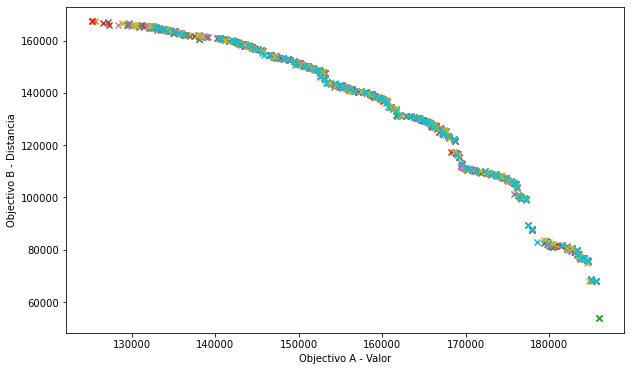

In [35]:
pop_size_ar = len(pareto_front_population[1])
num_objectives = len(pareto_front_population[1][0].fitness)
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
plt.figure(figsize=(10,6))
for j in range(10):
    
    for i in range(pop_size): fitnesses[i,:] = pareto_front_population[j][i].fitness
    x = fitnesses[:, 0]
    y = fitnesses[:, 1]
    plt.xlabel('Objectivo A - Valor')
    plt.ylabel('Objectivo B - Distancia')
    plt.scatter(x,y, marker="x")
    fitnesses = np.zeros([pop_size, num_objectives])
    plt.show

    #plt.savefig('pareto.png')
    df_result=display(pareto_front_population[j])
    df_result.to_csv('results_multibjetivo'+str(j)+'.csv',index=False,sep = ';')

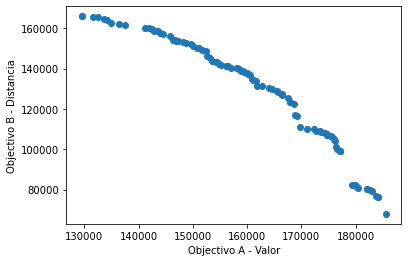

In [37]:
## Plotea la primera frontera de pareto
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0][0].fitness)
    
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[0][i].fitness

x = fitnesses[:, 0]
y = fitnesses[:, 1]
plt.xlabel('Objectivo A - Valor')
plt.ylabel('Objectivo B - Distancia')
plt.scatter(x,y, marker="o")
#plt.savefig('pareto.png')
plt.show()

In [85]:
display(pareto_front_population[0])

,Poblacion,fitness Poblacion,fitness Distancia
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",132200.0,165497.453892
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",133700.0,164385.790072
2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",144400.0,157382.018153
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...",166700.0,126830.221766
4,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",165100.0,129261.457941
...,...,...,...
95,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",152700.0,147794.140516
96,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",151600.0,149491.657894
97,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",150800.0,150232.881544
98,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",144800.0,156839.160940


In [28]:
df_result=display(pareto_front_population)
df_result

,Poblacion,fitness Poblacion,fitness Distancia
0,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",173500.0,108812.622494
1,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",151700.0,149459.180799
2,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",174900.0,107257.898372
3,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",145700.0,156080.087081
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",150700.0,150407.470555
...,...,...,...
95,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",149700.0,151764.471130
96,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...",160000.0,137819.384973
97,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...",160900.0,134776.889093
98,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, ...",132400.0,165422.084368


In [89]:
df_result.to_csv('results_multibjetivo.csv',index=False,sep = ';')

In [34]:
pop_size

100

### Mejor solución del monobjetivo

In [39]:
sol=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]

In [40]:
#evaluando el cromosoma
point=get_fitness(sol, ItemPool, 10)
point

array([144600.       , 157204.8449766])

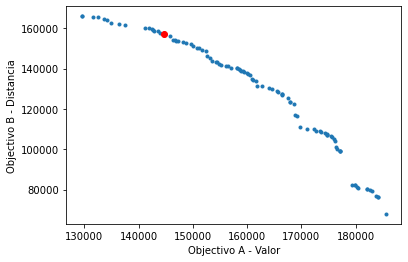

In [42]:
## Plotea la primera frontera de pareto
pop_size = len(pareto_front_population)
num_objectives = len(pareto_front_population[0][0].fitness)
    
# extrae los fitness de la poblacion en la matriz fitnesses
fitnesses = np.zeros([pop_size, num_objectives])
for i in range(pop_size): fitnesses[i,:] = pareto_front_population[0][i].fitness

x = fitnesses[:, 0]
y = fitnesses[:, 1]
plt.xlabel('Objectivo A - Valor')
plt.ylabel('Objectivo B - Distancia')
plt.scatter(x,y, marker=".")
plt.plot(point[0],point[1], marker="o", color="red")
#plt.savefig('pareto.png')
plt.show()




In [65]:
#Algunos de los valores del pareto front y su fitness:
for i in range(5):
    b = pareto_front_population[i].fitness
    print(b)

[135200.            544.71221123]
[137100.            540.26649273]
[172300.            366.88668034]
[144500.            523.89289031]
[147000.            513.44651583]


In [90]:
#Imprime las soluciones de la frontera en un fichero de texto
"""archi1=open("datos.csv","w")
archi1.write("Cromosoma#Poblacion#Distancia \n")
for i in range(len(pareto_front_population)):
    a = str(pareto_front_population[i].chromosome)
    b = str(pareto_front_population[i].fitness[0])
    c = str(pareto_front_population[i].fitness[1])
    texto=a+"#"+b+"#"+c+"\n"
    archi1.write(texto)    
archi1.close()  """

'archi1=open("datos.csv","w")\narchi1.write("Cromosoma#Poblacion#Distancia \n")\nfor i in range(len(pareto_front_population)):\n    a = str(pareto_front_population[i].chromosome)\n    b = str(pareto_front_population[i].fitness[0])\n    c = str(pareto_front_population[i].fitness[1])\n    texto=a+"#"+b+"#"+c+"\n"\n    archi1.write(texto)    \narchi1.close()  '